In [60]:
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [61]:
# Custom DataSet Class
import numpy as np
from PIL import Image 
import pandas as pd
from torchvision import transforms
import torch

class CustomDataSet(Dataset):
    def __init__(self, folder_path, csv_path, transforms = None):
        #get all the necessary parameters for directories, labels and transforms
        self.csv = pd.read_csv(csv_path)
        self.folder_path = folder_path
        self.transforms = transforms

    def __len__(self):
        #get the length of the dataset
        class_length = len(self.csv.iloc[:, 1])
        return class_length

    def __getitem__(self, idx):
        #get the dataset item and label and set transforms
        self.image_path_list = [os.path.join(self.folder_path, image_name) for image_name in self.csv.iloc[:, 0]]
        self.one_hot_label = pd.get_dummies(self.csv.iloc[:, 1])
        self.one_hot_label_list = self.one_hot_label.values.tolist()

        self.image_path = self.image_path_list[idx]
        self.image = Image.open(self.image_path)
        self.label = torch.tensor(self.one_hot_label_list[idx]).float()

        if self.transforms:
            self.image = self.transforms(self.image)

        sample = {'image': self.image, 'label': self.label}     

        return sample

In [62]:
# Parameters
import torch

image_size = (256, 256)
batch_size = 32

train_folder_path = r'C://Users//rolan//Desktop//Wooden_things//train'
train_csv_path = r'C://Users//rolan//Desktop//Wooden_things//train_csv.csv'

test_folder_path = r'C://Users//rolan//Desktop//Wooden_things//test'
test_csv_path = r'C://Users//rolan//Desktop//Wooden_things//test_csv.csv'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

save_model_path = r'Models'
save_plot_path = r'Plots'

In [63]:
# DataSet

image_transforms = transforms.Compose([transforms.Resize(size = image_size), transforms.ToTensor()]) # Noramlisation if needed #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_data = CustomDataSet(folder_path = train_folder_path, csv_path = train_csv_path, transforms = image_transforms)
test_data = CustomDataSet(folder_path = test_folder_path, csv_path = test_csv_path, transforms = image_transforms)

In [64]:
# DataLoaders
train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 32, shuffle = True)

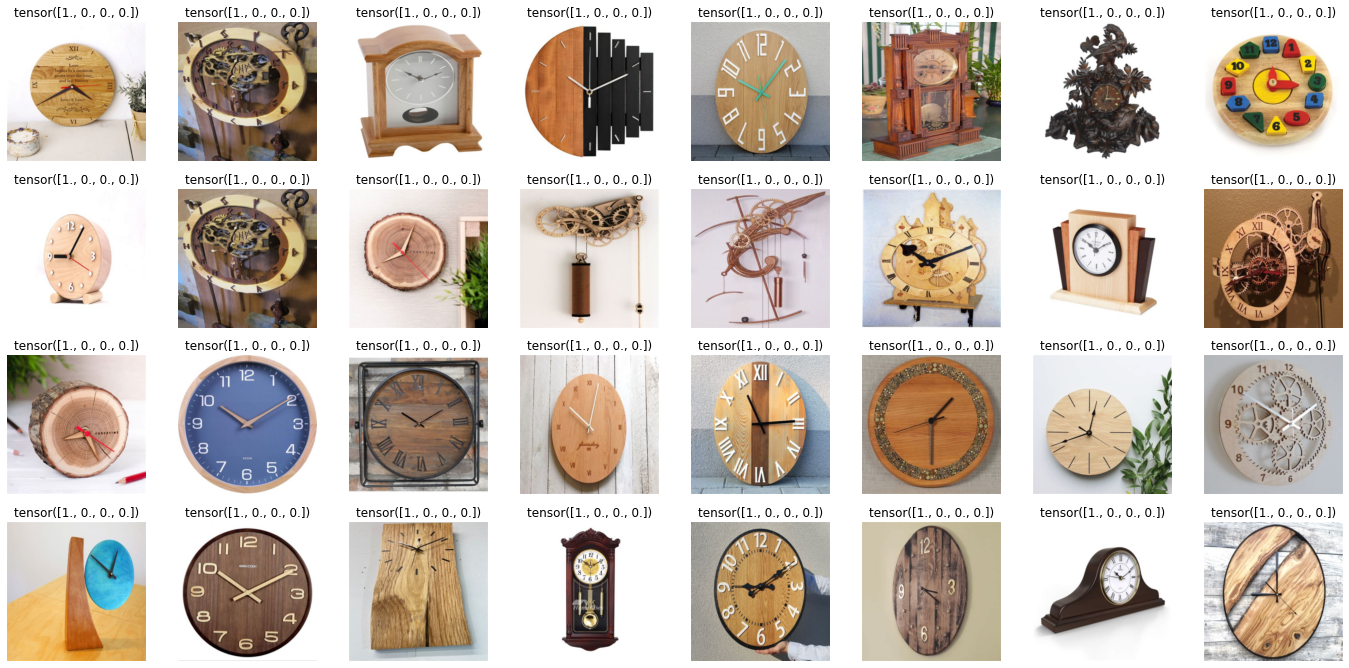

In [65]:
# Visualise batch data

import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import math
import os

def plot_batch_samples(data_loader, batch_size):

    log = math.log(batch_size, 2)
    rows = 2**math.ceil(log/2)
    columns = 2**math.ceil(log/2)

    fig = plt.figure(figsize = (3*columns, 3*rows), dpi = 72)

    for idx, sample in zip(list(range(batch_size)), data_loader):
        axis = fig.add_subplot(rows, columns, idx+1)
        np_image = sample['image'].numpy()
        np_image = np_image.transpose((1, 2, 0))
        axis.axis('off')
        axis.set_title(label = sample['label'])
        axis.imshow(np_image)
    plt.show()

plot_batch_samples(train_data, batch_size = batch_size)

#define as function

In [66]:
class LinearWood(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2, padding=0, dilation=1) #126
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1)#62
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=2, padding=0, dilation=1) #30
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1)#14
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=36, kernel_size=3, stride=2, padding=0, dilation=1) #6

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout2d(0.2)

    self.linear_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1296, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),      
        nn.Linear(64, 4),
        nn.Softmax(dim=1)
        )

  def forward(self, x):
    prediction = self.conv1(x)
    prediction = self.relu(prediction)
    prediction = self.dropout(prediction)

    prediction = self.maxpool1(prediction)

    prediction = self.conv2(prediction)
    prediction = self.relu(prediction)
    prediction = self.dropout(prediction)

    prediction = self.maxpool2(prediction)

    prediction = self.conv3(prediction)
    prediction = self.relu(prediction)
    prediction = self.dropout(prediction)

    prediction = self.linear_stack(prediction)

    return prediction

# Move to GPU
wt_model = LinearWood().to(device=device)

In [67]:
optimizer = torch.optim.Adam(params = wt_model.parameters(), lr=1e-3, weight_decay=0.00005, betas = (0.85, 0.99))
#optimizer = torch.optim.SGD(params = wt_model.parameters(), lr=0.2, weight_decay=0.0001)

loss = nn.CrossEntropyLoss()

In [68]:
#Define training

def train(model, loss_function, optimizer, the_data_loader):
    model.train()
    train_loss_list = []

    #Itterate through the dataset
    for idx, (sample_batch) in enumerate(the_data_loader):
        image = sample_batch['image']
        label = sample_batch['label']
        image, label = image.to(device), label.to(device)

        prediction = model.forward(image)

        loss = loss_function(prediction, label)
        train_loss_list.append(loss.item())

        loss.backward()
        #initialise the optimiser
        optimizer.step()
        #reset the gradients
        optimizer.zero_grad()

        if idx % 10 == 0:
            print(f'The loss is:{loss.item()}')
    return train_loss_list

In [69]:
def test(model, loss_function, dataloader, dataset):
    batchsize = len(dataloader)
    dataset_length = len(dataset)
    test_loss, total_correct_guesses = 0, 0

    model.eval()
    with torch.no_grad():
        for sample_batch in dataloader: #sample_batch
            input = sample_batch['image']
            label = sample_batch['label']
            input, label = input.to(device), label.to(device)

            output = model.forward(input)
            test_loss += loss_function(output, label)
            total_correct_guesses += (output.argmax(1) == torch.argmax(label, dim=1)).type(torch.float).sum().item()

    avr_loss = test_loss / batchsize
    avr_loss = '{:f}'.format(avr_loss)
    accuracy = total_correct_guesses / dataset_length

    print(f'Model Accuracy: {accuracy*100}% \n Average Loss {avr_loss}')

    return avr_loss, accuracy*100

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime

def train_loop(epochs):
    train_loss_list = []
    test_loss_list = []
    accuracy_list= []
    current_time = str(datetime.now()).replace(' ', '').replace('.', '').replace(':', '')

    for idx, i in enumerate(range(epochs)):
        print(f'Epoch{i+1} \n --------------------------------------')

        #train the model
        train_loss = train(model = wt_model, loss_function = loss, optimizer = optimizer, the_data_loader = train_loader)
        test_loss, accuracy = test(model = wt_model, loss_function = loss, dataloader = test_loader, dataset = test_data)

        '''plot the graphs as the model trains'''
        #sort the data for the plots        
        for i in train_loss:
            train_loss_list.append(round(i, 3))
        test_loss_list.append(round(float(test_loss), 3))
        accuracy_list.append(accuracy)

        #close previous plots to free up memory
        plt.close('all')
        
        #create and format the figure
        loss_fig, (ax_train, ax_test, ax_acc) = plt.subplots(nrows=3, ncols=1)
        loss_fig.set_size_inches(5, 5)
        loss_fig.set_dpi(72)
        plt.subplots_adjust(hspace=1, wspace=1)

        #plot the data on the axes
        ax_train.plot(list(range(len(train_loader)*(idx+1))), train_loss_list, color='#1f77b4')
        ax_train.set_title('Training Loss/batch')
        ax_train.set_xlabel('Batches')
        ax_train.set_ylabel('Loss')
        ax_train.grid(True)

        ax_test.plot(list(range(idx+1)), test_loss_list, color='#ff7f0e')
        ax_test.set_title('Test Loss/Epoch')
        ax_test.set_xlabel('Epochs')
        ax_test.set_ylabel('Loss')
        ax_test.grid(True)

        ax_acc.plot(list(range(idx+1)), accuracy_list, color='#2ca02c')
        ax_acc.set_title('Model Accuracy')
        ax_acc.set_xlabel('Epochs')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.grid(True)

        #save the model
        a = 0
        if idx % 10 == 0:
            a += 1
            torch.save(obj = wt_model.state_dict(), f=f'{save_model_path}//Experiment_{a}_{current_time[:-12]}_{str(accuracy)[:2]}.pth')
            print(f'Saved model as Experiment_{a}.pth')
        print('Finished')

        #plt.pause(0.1)
        plt.show()

        loss_fig.savefig(fname=f'{save_plot_path}//model_x_{current_time}.pdf', dpi=300)



In [ ]:
train_loop(epochs = 81)